# LunAPI : staging

Links to notebooks in this repository: [Index](./00_overview.ipynb) | [Individuals](./01_indivs.ipynb) | [Projects](./02_projects.ipynb) | [Staging](./03_staging.ipynb) | [Models](./04_models.ipynb) | [Advanced](./98_advanced.ipynb) | [Reference](./99_reference.ipynb)

---

Here we give an example of using the POPS stager.  We assume this is running the Docker version of `lunapi` which bundles these resources.  Otherwise, the POPS resource folder can be downloaded from [this URL](https://gitlab-scm.partners.org/zzz-public/nsrr/-/tree/master/common/resources/pops?ref_type=heads) (and as shown below, change the `resource` object to point to this downloaded `pops` folder). 


In [1]:
import lunapi as lp
proj = lp.proj()

initiated lunapi v0.0.5 <lunapi.lunapi0.luna object at 0x7f8343ff8870> 



We'll start off which the NSRR tutorial dataset as usual (three PSGs in older adults):

In [2]:
proj.sample_list( 'tutorial/s.lst' )

read 3 individuals from tutorial/s.lst


In [3]:
proj.sample_list()

[('learn-nsrr01',
  'tutorial/edfs/learn-nsrr01.edf',
  {'tutorial/edfs/learn-nsrr01.xml'}),
 ('learn-nsrr02',
  'tutorial/edfs/learn-nsrr02.edf',
  {'tutorial/edfs/learn-nsrr02.xml'}),
 ('learn-nsrr03',
  'tutorial/edfs/learn-nsrr03.edf',
  {'tutorial/edfs/learn-nsrr03.xml'})]

---
## POPS on a single individual

We'll start by selecting a single individual from the sample list:

In [4]:
p = proj.inst( 1 )

___________________________________________________________________
Processing: learn-nsrr02 | tutorial/edfs/learn-nsrr02.edf
 duration 09.57.30, 35850s | time 21.18.06 - 07.15.36 | date 01.01.85

 signals: 14 (of 14) selected in a standard EDF file
  SaO2 | PR | EEG_sec | ECG | EMG | EOG_L | EOG_R | EEG
  AIRFLOW | THOR_RES | ABDO_RES | POSITION | LIGHT | OX_STAT


### Basic usage (single channel EEG)

As mentioned above, if you downloaded the POPS resource folder separate, you need to set `lp.resources.POPS_PATH` to point to it. For this notebook, `pops` is in the root folder, so we can just set to this.  (When using the `lunapi` Docker, this is set to the right locations and should not need to be changed.)

In [9]:
lp.resources.POPS_PATH = 'pops'

We'll start with a single-channel EEG example:

In [10]:
stgs = p.pops( 'EEG' )

 ..................................................................
 CMD #1: COPY
   options: sig=EEG tag=F
 copying EEG to EEG_F
 ..................................................................
 CMD #2: RESAMPLE
   options: sig=EEG_F sr=128
  resampling channel EEG_F from sample rate 125 to 128
 ..................................................................
 CMD #3: FILTER
   options: bandpass=0.3,35 ripple=0.01 sig=EEG_F tw=0.2
  filtering channel(s): EEG_F
 ..................................................................
 CMD #4: COPY
   options: sig=EEG_F tag=N
 copying EEG_F to EEG_F_N
 ..................................................................
 CMD #5: ROBUST-NORM
   options: epoch sig=EEG_F_N winsor=0.002
  set epochs to default 30 seconds, 1195 epochs
  iterating over epochs
  robust standardization of 1 signals, winsorizing at 0.002
 ..................................................................
 CMD #6: EDGER
   options: cache=ec1 sig=EEG_F
  skipping... 

### Predictions

The individual-level `pops()` function returns a table of posterior probabilities, one row per epoch, for the probability of a given stage, and other information - this is the same table as reported by `table( 'POPS' , 'E' )`:

In [11]:
stgs

,ID,E,CONF,FLAG,PP_N1,PP_N2,PP_N3,PP_R,PP_W,PRED,PRIOR,START,STOP
0,learn-nsrr02,1,0.998897,0,0.000605,0.000325,0.000068,0.000105,0.998897,W,W,21:18:06,21:18:36
1,learn-nsrr02,2,0.998959,0,0.000579,0.0003,0.000064,0.000098,0.998959,W,W,21:18:36,21:19:06
2,learn-nsrr02,3,0.998638,0,0.000766,0.000399,0.000069,0.000128,0.998638,W,W,21:19:06,21:19:36
3,learn-nsrr02,4,0.99802,0,0.001195,0.000556,0.000074,0.000155,0.99802,W,W,21:19:36,21:20:06
4,learn-nsrr02,5,0.997083,0,0.001719,0.000891,0.000089,0.000216,0.997083,W,W,21:20:06,21:20:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,learn-nsrr02,1191,None,-1,None,None,None,None,None,None,None,07:13:06,07:13:36
1191,learn-nsrr02,1192,None,-1,None,None,None,None,None,None,None,07:13:36,07:14:06
1192,learn-nsrr02,1193,None,-1,None,None,None,None,None,None,None,07:14:06,07:14:36
1193,learn-nsrr02,1194,None,-1,None,None,None,None,None,None,None,07:14:36,07:15:06


### Hypnogram plots

Pulling the whole epoch-level result table out, we can use some helper functions to make a hypnogram:

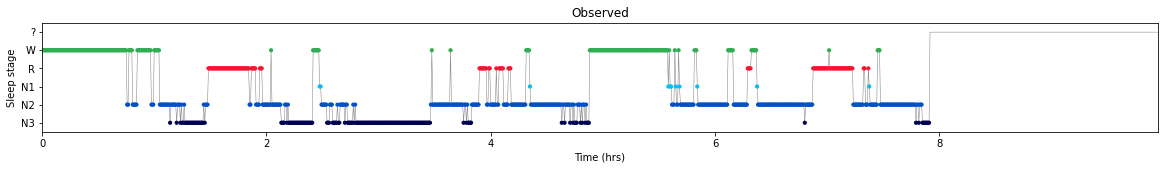

In [12]:
lp.hypno( ss = stgs['PRIOR'] , title = "Observed" ) 

The above was based on the original (`PRIOR`) sleep stages; below we can make the same plot for predicted stages too, which looks very similar:

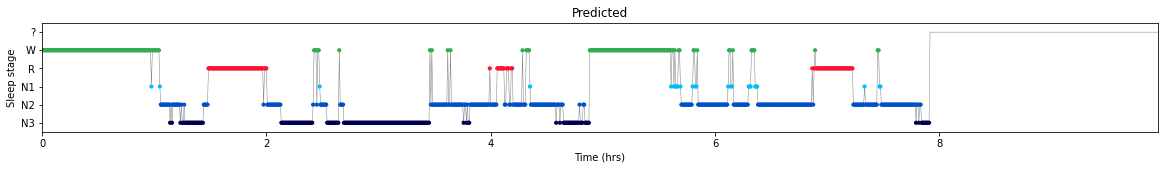

In [13]:
lp.hypno( ss = stgs['PRED'] , title = "Predicted" ) 

Note that `pops()` by default runs Luna's `EDGER` command to splice out any clearly artifactual leading or trailing periods (which are typically wake, but also typically very noisy).  Removing such epochs can improve model performance.  This is why the final stages of the first hypnogram above end in `?` rather than `W`.  (Re-running `pops()` with `do_edger = False` would change this behavior.)

### Hypnodensity plots

As well as hypnograms, we can plot a more quantitative representation of the night, by plotting the posterior probabilities of each epoch (using the same color scheme as implied above):

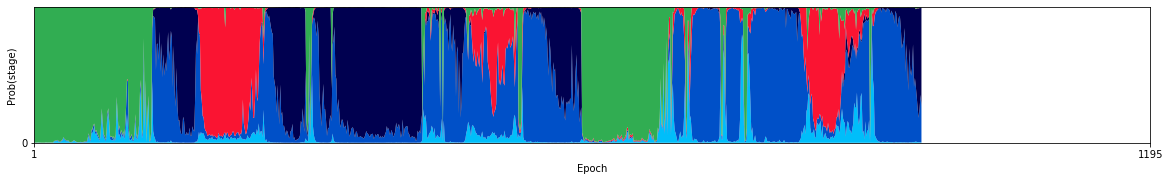

In [14]:
lp.hypno_density( stgs )

### Stage statistics

We can also extract _stage-specific_ summary information from the `SS` strata of the output: e.g. here observed (`OBS`/`ORIG`) and predict (`PR1`/`PRF`) stage durations in minutes:

In [15]:
p.table( 'POPS' , 'SS' )

,ID,SS,F1,OBS,ORIG,PR1,PREC,PRF,RECALL
0,learn-nsrr02,?,None,122.5,122.5,122.5,None,122.5,None
1,learn-nsrr02,N1,0.277778,5.5,5.5,12.5,0.2,24.438097,0.454545
2,learn-nsrr02,N2,0.872679,199.0,199.0,178.0,0.924157,171.967273,0.826633
3,learn-nsrr02,N3,0.905371,92.5,92.5,103.0,0.859223,100.595013,0.956757
4,learn-nsrr02,R,0.831933,60.0,60.0,59.0,0.838983,59.986418,0.825
5,learn-nsrr02,W,0.931393,118.0,118.0,122.5,0.914286,118.013199,0.949153


### Model performance

We can get information on the model performance (for the case when original staging information exist) from the _baseline_ `POPS` outputs:

In [16]:
p.table( 'POPS' ).T

,0
ID,learn-nsrr02
ACC,0.877895
ACC3,0.925263
CONF,0.832661
F1,0.763831
F13,0.901634
F1_WGT,0.881596
K,0.830578
K3,0.860016
MCC,0.832258


## Project-level invocation

Rather than running one individual at a time, we can use the _project-level_ `pops()` which provides the same functions, but for a sample list rather than one individual.  (Note: of course, it would be trivial to write a loop to process one individual at a time, although using the built-in project-level option can be useful, e.g. to keep all output together naturally, etc).    Because this generates quite a lot of output, we'll first silence the console, and then run `pops()` on the sample list (i.e. here, via `proj` rather than `p`).  This will take a minute or so to complete:

In [17]:
proj.silence()
proj.pops( 'EEG' )

,ID,ACC,ACC3,CONF,F1,F13,F1_WGT,K,K3,MCC,...,PREC,PREC3,PREC_WGT,RECALL,RECALL3,RECALL_WGT,REM_LAT_OBS,REM_LAT_PRD,SLP_LAT_OBS,SLP_LAT_PRD
0,learn-nsrr01,0.704762,0.812381,0.716862,0.490478,0.775344,0.691719,0.555933,0.658378,0.561066,...,0.492838,0.768374,0.693173,0.543379,0.787645,0.704762,55.5,123.0,26.5,41.5
1,learn-nsrr02,0.877895,0.925263,0.832661,0.763831,0.901634,0.881596,0.830578,0.860016,0.832258,...,0.74733,0.900153,0.889916,0.802418,0.903393,0.877895,43.5,30.5,45.5,58.5
2,learn-nsrr03,0.668838,0.750271,0.782714,NaN,NaN,NaN,0.452682,0.509111,0.49368,...,0.429016,0.54933,0.766778,NaN,NaN,NaN,None,93.0,56.0,58.0


In project model, `pops()` outputs the model performance statistics when finishing.

In [18]:
proj.table( 'POPS' ) 

,ID,ACC,ACC3,CONF,F1,F13,F1_WGT,K,K3,MCC,...,PREC,PREC3,PREC_WGT,RECALL,RECALL3,RECALL_WGT,REM_LAT_OBS,REM_LAT_PRD,SLP_LAT_OBS,SLP_LAT_PRD
0,learn-nsrr01,0.704762,0.812381,0.716862,0.490478,0.775344,0.691719,0.555933,0.658378,0.561066,...,0.492838,0.768374,0.693173,0.543379,0.787645,0.704762,55.5,123.0,26.5,41.5
1,learn-nsrr02,0.877895,0.925263,0.832661,0.763831,0.901634,0.881596,0.830578,0.860016,0.832258,...,0.74733,0.900153,0.889916,0.802418,0.903393,0.877895,43.5,30.5,45.5,58.5
2,learn-nsrr03,0.668838,0.750271,0.782714,NaN,NaN,NaN,0.452682,0.509111,0.49368,...,0.429016,0.54933,0.766778,NaN,NaN,NaN,None,93.0,56.0,58.0


We can access the full sets of outputs from the usual `proj` results cache (i.e. the same as if we had run any command(s) with `eval()`):

In [19]:
proj.strata()

,Command,Stratum
0,EDGER,BL
1,EDGER,CH
2,POPS,BL
3,POPS,E
4,POPS,ETYPE
5,POPS,ETYPE_SS
6,POPS,FTR
7,POPS,OBS_PRED
8,POPS,SS


For example, to pull all stage durations from the three individuals:

In [20]:
proj.table( 'POPS' , 'SS' )

,ID,SS,F1,OBS,ORIG,PR1,PREC,PRF,RECALL
0,learn-nsrr01,?,None,157.0,157.0,157.0,None,157.0,None
1,learn-nsrr02,?,None,122.5,122.5,122.5,None,122.5,None
2,learn-nsrr03,?,None,221.5,221.5,221.5,None,221.5,None
3,learn-nsrr01,N1,0.046512,54.5,54.5,10.0,0.15,51.392146,0.027523
4,learn-nsrr02,N1,0.277778,5.5,5.5,12.5,0.2,24.438097,0.454545
5,learn-nsrr03,N1,0.170213,26.0,26.0,21.0,0.190476,45.447093,0.153846
6,learn-nsrr01,N2,0.818438,261.5,261.5,270.0,0.805556,240.527679,0.83174
7,learn-nsrr02,N2,0.872679,199.0,199.0,178.0,0.924157,171.967273,0.826633
8,learn-nsrr03,N2,0.719915,187.5,187.5,282.0,0.599291,233.568652,0.901333
9,learn-nsrr01,N3,0.12766,8.5,8.5,38.5,0.077922,43.600179,0.352941


The second individual (`learn-nsrr02`) should have the same performance statistics as above.   We see the _kappa_ values are a little lower for the other two test individuals:

In [21]:
proj.table( 'POPS' )[ ['ID','K'] ]

,ID,K
0,learn-nsrr01,0.555933
1,learn-nsrr02,0.830578
2,learn-nsrr03,0.452682


Although a full treatment is beyond the scope of this tutorial, we can take a look at the original hypnograms to perhaps get a sense of what is happening, and how the staging compares overall.  We'll pull out all epoch-level outputs, and then focus on the first individual:

In [22]:
stgs = proj.table( 'POPS' , 'E' ) 
df1 = stgs[ stgs['ID'] == 'learn-nsrr01' ]
df1

,ID,E,CONF,FLAG,PP_N1,PP_N2,PP_N3,PP_R,PP_W,PRED,PRIOR,START,STOP
0,learn-nsrr01,1,None,-1,None,None,None,None,None,None,None,21:58:17,21:58:47
3,learn-nsrr01,2,None,-1,None,None,None,None,None,None,None,21:58:47,21:59:17
6,learn-nsrr01,3,None,-1,None,None,None,None,None,None,None,21:59:17,21:59:47
9,learn-nsrr01,4,None,-1,None,None,None,None,None,None,None,21:59:47,22:00:17
12,learn-nsrr01,5,None,-1,None,None,None,None,None,None,None,22:00:17,22:00:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,learn-nsrr01,1360,None,-1,None,None,None,None,None,None,None,09:17:47,09:18:17
3915,learn-nsrr01,1361,None,-1,None,None,None,None,None,None,None,09:18:17,09:18:47
3917,learn-nsrr01,1362,None,-1,None,None,None,None,None,None,None,09:18:47,09:19:17
3919,learn-nsrr01,1363,None,-1,None,None,None,None,None,None,None,09:19:17,09:19:47


We will plot the hypnograms: first the observed staging, then the predicted:

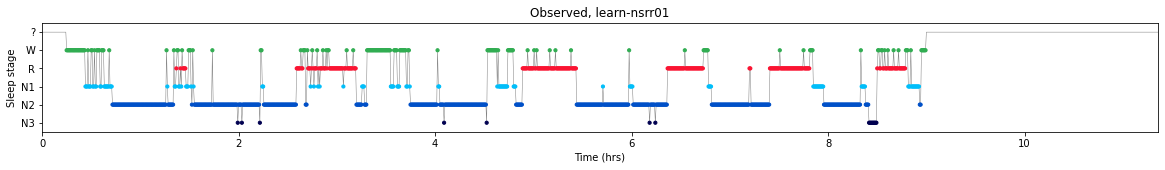

In [23]:
lp.hypno( df1[ 'PRIOR' ] , title = "Observed, learn-nsrr01" ) 

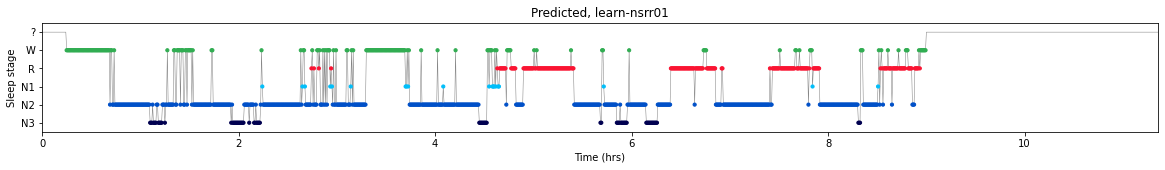

In [24]:
lp.hypno( df1[ 'PRED' ] , title = "Predicted, learn-nsrr01" ) 

The main differences here a) we predict more N3 during the NREM periods - the positioning of the N3 is consistent with our expectations for sleep cycles in general; b) less REM (R/red) is predict during the first cycle.

Doing the same thing for the third tutorial individual:

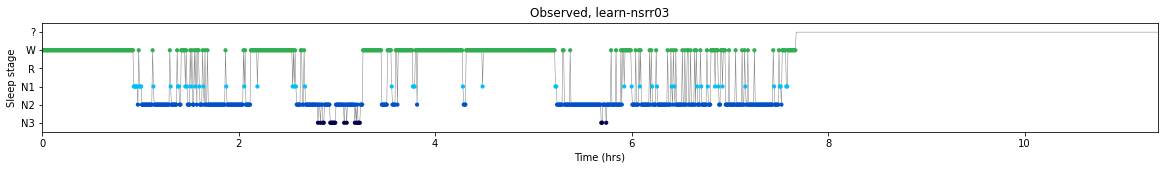

In [25]:
df3 = stgs[ stgs['ID'] == 'learn-nsrr03' ]
lp.hypno( df3[ 'PRIOR' ] , title = "Observed, learn-nsrr03" ) 

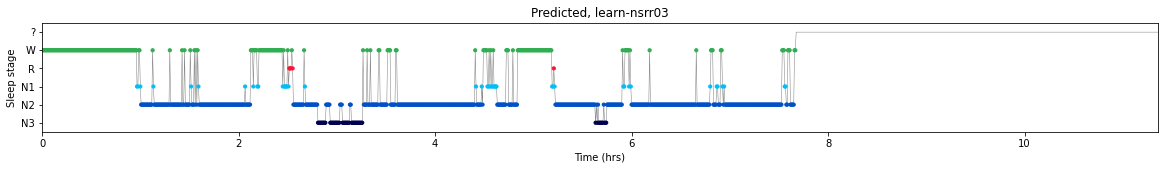

In [26]:
lp.hypno( df3[ 'PRED' ] , title = "Predicted, learn-nsrr03" ) 

The kappa is relatively low here (around 0.5) although there is clear correspondence;  neither hypnogram has a great deal of REM and the original clearly has a lot of N1 - this is likely consistent with generally light and fragmented sleep which is typically harder to stage.  The other major differ is that prediction includes a longer period of N2 sleep around hour 4, whereas the observed staging denotes this as largely wake. 

### Deeper dive: alternate EEG channel

Focussing on `learn-nsrr03`, we'll take a look at the second EEG channel (`EEG_sec`), using the individual-level `pops()` and directly pulling the epoch-level output from `pops()`:

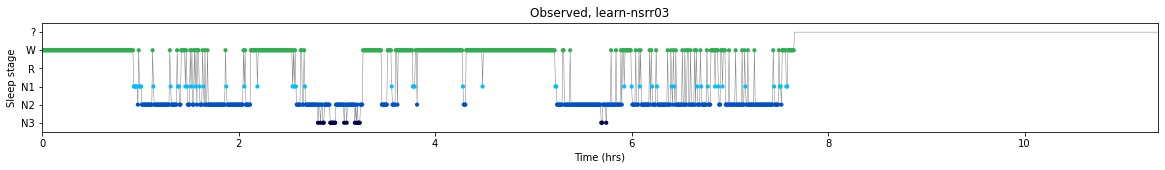

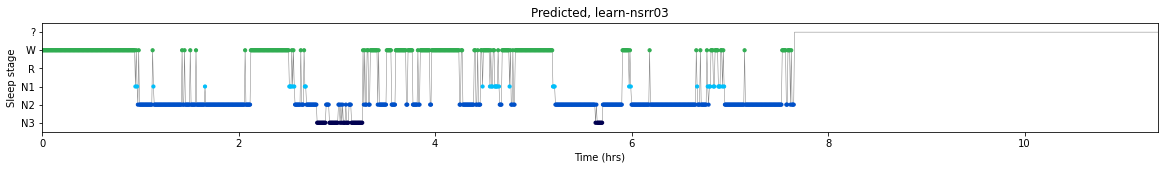

In [27]:
p = proj.inst( proj.get_n( 'learn-nsrr03' ) ) 
stgs = p.pops( 'EEG_sec' )
lp.hypno( stgs[ 'PRIOR' ] , title = "Observed, learn-nsrr03" )
lp.hypno( stgs[ 'PRED' ] , title = "Predicted, learn-nsrr03" ) 

These kappa values are now higher: the three class kappa is 0.74 and now there is more wake called around hour four: 

In [28]:
p.table( 'POPS' )[ ['K','K3'] ]

,K,K3
0,0.643516,0.742307


### Channel review

We will use the `PSD` command to generate whole-night spectrograms for each individual/channel:

In [29]:
res = proj.eval( 'PSD sig=EEG,EEG_sec dB epoch-spectrum' )

The helper function `lp.spec()` can be used to plot spectrograms, by extracting the channel-by-epoch-by-frequency-bin (`CH_E_F`, i.e. the strata in alphabetical order):

In [30]:
res = proj.table( 'PSD' , 'CH_E_F' )

In [31]:
res

,ID,CH,E,F,PSD
0,learn-nsrr01,EEG,1,0.5,17.230154
1,learn-nsrr02,EEG,1,0.5,17.053865
2,learn-nsrr03,EEG,1,0.5,17.978639
3,learn-nsrr01,EEG,1,0.75,15.976193
4,learn-nsrr02,EEG,1,0.75,12.864764
...,...,...,...,...,...
776749,learn-nsrr03,EEG_sec,1364,24.5,12.850443
776750,learn-nsrr01,EEG_sec,1364,24.75,6.072284
776751,learn-nsrr03,EEG_sec,1364,24.75,13.215112
776752,learn-nsrr01,EEG_sec,1364,25.0,9.740561


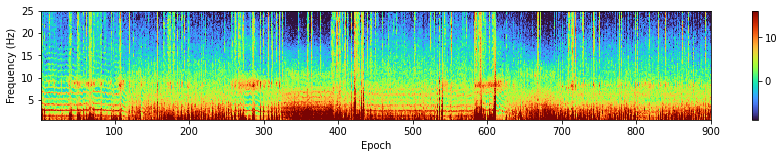

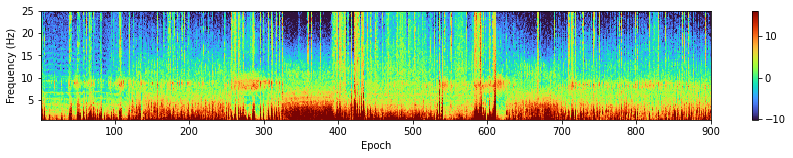

In [32]:
df = res[ res['ID'] == 'learn-nsrr03' ] 
lp.spec( df , ch = 'EEG' , maxe=900 )
lp.spec( df , ch = 'EEG_sec' , maxe=900 )

### Multi-channel models

Luna and POPS support full multi-channel models (i.e. models trained on multiple EEG and/or other channels).   Currently we only distribute a single channel model (called, perhaps confusingly, `s2`).  However, `POPS` is able to consider multiple different EEG channels (one at-a-time), fitting the single-channel models, and then compiling the most confident result for each epoch.  Using the `pops()` wrapper, we simply specify `s1` and `s2` separately. (The basic POPS command can take more than two channels if this is needed.

This speaks to the previous issue, of the two EEGs giving different results, by providing a principled way to use both available channels (here one is `C3-M2` and the other is `C4-M1`, which were the two central (contralateral mastoid referenced channels used).   Running just for the third individual (this is still linked to `p`):

In [33]:
p

<lunapi-instance id:learn-nsrr03 edf:tutorial/edfs/learn-nsrr03.edf annot:tutorial/edfs/learn-nsrr03.xml>

In [34]:
p.pops( 'EEG' )
p.table( 'POPS' )[ ['K','K3'] ]

,K,K3
0,0.452682,0.509111


In [35]:
p.pops( 'EEG_sec' )
p.table( 'POPS' )[ ['K','K3'] ]

,K,K3
0,0.641728,0.740156


In [36]:
p.pops( s1 = 'EEG' , s2 = 'EEG_sec' )
p.table( 'POPS' )[ ['K','K3'] ]

,K,K3
0,0.553679,0.627971


Overall, we've seen the version using both channels has performance midway between the two single-channel models.  Naturally, in real applications where we don't have the true staging, we won't get this information. The multi-channel approach generally tries to avoid the worst-case scenario (as does inspecting the signal properties of the channels prior to staging, i.e. avoiding very noisy channels, etc).

## Options

Both project-level and individual-level `pops()` have several options (the method is identical between both).

| Option | Default |Description |
|----|----|----|
| `s` | None | EEG label for signal channel |
| `do_edger` | `True` | Run `EDGER` prior to fitting, or not |
| `no_filter` | `False` | Assume signals are already bandpass filtered, or not |
| `do_reref` | `False` | Perform re-referencing, or not |
| `m` | None | Mastoid channel (if `do_reref=True`)|

If `do_reref` is `True` then `m` must be set: e.g. 

```
p.pops( s = 'C3' , m = 'M2' , do_reref = True )
```

The multi-channel version is as above, expcept `s` and `m` are replaced with `s1`, `s2` and `m1`, `m2`: e.g.:

```
p.pops( s1 = 'C3' , m1 = 'M2' , s2 = 'C4' , m2 = 'M1' , do_reref = True )
```


## Notes

If the POPS training data are located elsewhere (i.e. if not running in a remnrem/lunapi docker context), you can point to the enclosing folder by setting this variable before running `p.pops()`:

That completes this overview of POPS in the `lunapi` workflow.  You can see how to use prediction models in the [next notebook](./04_models.ipynb).